In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import geopandas
import scipy
import fiona

# a)Data input

In [114]:
fiona.drvsupport.supported_drivers['KML'] = 'rw'
df_gas = pd.read_csv('data/TotalHouseholdTownGasConsumptionbyDwellingType2005toJun2021.csv') #hdb gas consumtion
df_gm = pd.read_csv('data/ListingofBuildingEnergyPerformanceData2020.csv') #building with green mark
dg_gm = geopandas.read_file('data/GreenMarkBuildingsGEOJSON.geojson') #green mark building location
dg_ec = geopandas.read_file('data/AverageMonthlyHouseholdElectricityConsumptionbyURAPlanningAreaDwellingType2009.kml',driver='kml')#hdb energy consumption
df_sp = pd.read_csv('data/SolarPVInstallationsbyURAPlanningRegion.csv')
dg_pa = geopandas.read_file('data/MasterPlan2019PlanningAreaBoundaryNoSea.geojson')
dg_nb = geopandas.read_file('zip://data/MP14SDCPPWPLANNatureBoundarySHP.zip')
dg_pl = geopandas.read_file('zip://data/MasterPlan2014PlanningAreaBoundaryWebSHP.zip')

# b)loc function


In [3]:
pd.set_option('display.max_columns', None)
df_gas.head()

,month,housing_type,dwelling_type,tg_consumption_gwh
0,2005-01,Public Housing,1-Room / 2-Room,1.1
1,2005-01,Public Housing,3-Room,6.6
2,2005-01,Public Housing,4-Room,16.0
3,2005-01,Public Housing,5-Room and Executive,17.4
4,2005-01,Private Housing,Private Apartments and Condominiums,5.9


In [4]:
print(df_gas['dwelling_type'].unique())

['1-Room / 2-Room' '3-Room' '4-Room' '5-Room and Executive'
 'Private Apartments and Condominiums' 'Landed Properties' 'Others']


In [5]:
df_gas.loc[df_gas['housing_type']=='Public Housing',['housing_type','tg_consumption_gwh']].describe()
#summary stat of gas consumption in public housing

,tg_consumption_gwh
count,784.000000
mean,10.865306
std,7.453757
min,1.000000
25%,4.875000
50%,12.550000
75%,17.900000
max,31.100000


In [6]:
df_gas.loc[df_gas['housing_type']=='Private Housing',['housing_type','tg_consumption_gwh']].describe()
#summary stat of gas consumption in private housing

,tg_consumption_gwh
count,392.000000
mean,6.139796
std,5.950611
min,0.900000
25%,0.900000
50%,3.550000
75%,10.500000
max,23.600000


In [7]:
df_gas['year'] = df_gas['month'].str.slice(0, 4)
df_gas.loc[df_gas['year']=='2005',['year','tg_consumption_gwh']].describe()
#summary stat of gas consumption in 2005

,tg_consumption_gwh
count,84.000000
mean,6.859524
std,6.576979
min,0.500000
25%,1.000000
50%,6.000000
75%,15.625000
max,17.700000


# c) tables


In [8]:
df_gas.groupby('dwelling_type')['tg_consumption_gwh'].describe()
#summary stat of gas consumption for each dwelling type

,count,mean,std,min,25%,50%,75%,max
dwelling_type,,,,,,,,
1-Room / 2-Room,196.0,1.234184,0.227596,1.0,1.000,1.1,1.400,2.1
3-Room,196.0,6.234694,0.426218,5.8,6.000,6.2,6.300,9.9
4-Room,196.0,17.621429,1.900054,15.2,16.400,17.4,18.400,31.1
5-Room and Executive,196.0,18.370918,1.398542,16.6,17.700,18.2,18.725,30.1
Landed Properties,196.0,0.951531,0.077444,0.9,0.900,0.9,1.000,1.4
Others,196.0,0.748469,0.509245,0.1,0.200,1.0,1.200,1.4
Private Apartments and Condominiums,196.0,11.328061,4.108874,5.7,7.975,10.5,14.225,23.6


In [9]:
df_gm.groupby('greenmarkrating')['2020'].describe()
#summary stat of energy performance in 2020 for each green mark rating
#How ever this doesnt show much since the diffrence between each building's gfa within every group can be huge

,count,mean,std,min,25%,50%,75%,max
greenmarkrating,,,,,,,,
Certified,26.0,228.251923,166.915269,51.40,123.6425,192.710,261.9200,752.78
Gold,83.0,242.783253,152.925206,37.41,141.5100,200.660,291.9500,822.63
GoldPlus,60.0,258.098667,142.944963,62.69,159.1350,214.340,306.6175,712.95
Legislated,22.0,248.104091,168.743369,27.14,120.0375,220.425,341.5100,684.22
Platinum,126.0,212.362063,141.753956,19.96,127.7425,172.375,261.8075,1157.40


In [10]:
df_gm['gfa'] = df_gm['grossfloorarea'].str.replace(',', '').astype(int)
#since original data is considered as string, hv to convert into integer
df_gm.groupby('greenmarkrating')['gfa'].describe()
#Summary stat of the gross floor area for each rating

,count,mean,std,min,25%,50%,75%,max
greenmarkrating,,,,,,,,
Certified,26.0,41365.115385,85763.740684,5901.0,15293.25,19099.0,33940.75,452045.0
Gold,83.0,41279.240964,60740.572002,5000.0,13546.00,26417.0,45193.50,490516.0
GoldPlus,60.0,41239.183333,33850.351508,5030.0,19421.00,30941.5,52581.75,170856.0
Legislated,22.0,30226.000000,82492.008346,757.0,3305.25,7591.5,13627.50,383038.0
Platinum,126.0,60721.761905,77781.618321,6407.0,21190.00,35968.5,70430.50,581511.0


# d)graphs


In [11]:
df_sp.head()

,year,ura_planning_region,residential_status,num_solar_pv_inst,inst_cap_kwac,total_inst_cap_percent
0,2008,Central,Non-Residential,4,73.2,30.0
1,2008,Central,Residential,4,19.9,10.0
2,2008,East,Non-Residential,1,2.3,0.0
3,2008,East,Residential,1,6.6,0.0
4,2008,North-East,Non-Residential,10,65.3,20.0


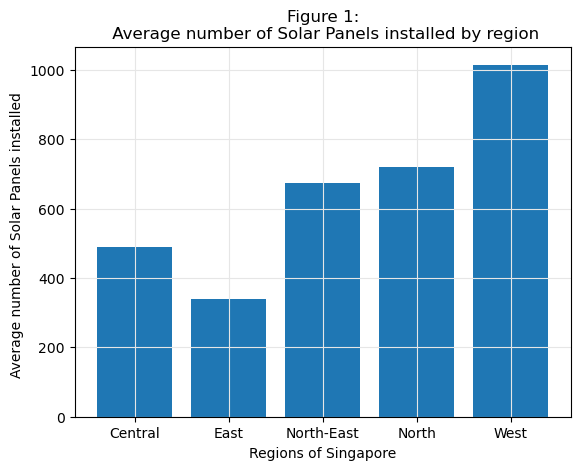

In [12]:
fig, ax = plt.subplots()
dg_sp = df_sp.groupby('year').mean(numeric_only=True)
plt.bar(df_sp['ura_planning_region'],df_sp['num_solar_pv_inst'])
plt.title('Figure 1:\n Average number of Solar Panels installed by region')
plt.xlabel('Regions of Singapore')
plt.ylabel('Average number of Solar Panels installed ')
plt.grid(color=(.9,.9,.9))
#fig.savefig('Figures/Figure 1.png')

In [13]:
df_gm.head()

,buildingname,buildingaddress,buildingtype,mainbuildingfunction,buildingsize,yearobtainedtopcsc,greenmarkrating,greenmarkyearofaward,greenmarkversion,greenmarkstatus,grossfloorarea,percentageofairconditionedfloorarea,averagemonthlybuildingoccupancyrate,numberofhotelrooms,typeofairconditioningsystem,ageofchiller,centralisedairconditioningplantefficiency,yearoflastchillerplantaudithealthcheck,percentageusageofled,installationofsolarpv,2017,2018,2019,2020,gfa
0,UNITED SQUARE,"101 THOMSON ROAD, SINGAPORE 307591",Commercial Building,Mixed Development,Large,1984,NaN,NaN,NaN,No,"65,947",93%,90%,NaN,Water Cooled Chilled Water Plant,12.0,0.68,2019.0,2%,N,281.32,276.83,274.91,250.89,65947
1,HPL HOUSE,"50 CUSCADEN ROAD, SINGAPORE 249724",Commercial Building,Office,Small,1980,NaN,NaN,NaN,No,"7,372",97%,90%,NaN,Others,2.0,NaN,NaN,80%,N,277.93,268.76,264.79,216.27,7372
2,GRACE GLOBAL RAFFLES,"137 MARKET STREET, SINGAPORE 048943",Commercial Building,Office,Small,2011,GoldPlus,2010.0,New Building for Non-Residential buildings (ve...,Yes,"5,030",80%,97%,NaN,Others,9.0,NaN,NaN,20%,N,171.16,165.32,165.52,115.42,5030
3,THE GLOBE,"100 CECIL STREET, SINGAPORE 069532",Commercial Building,Office,Small,1993,NaN,NaN,NaN,No,"5,824",70%,58%,NaN,Others,0.0,NaN,NaN,30%,N,185.64,168.50,163.46,138.01,5824
4,HIGH STREET PLAZA,"77 HIGH STREET, SINGAPORE 179433",Commercial Building,Office,Small,1975,NaN,NaN,NaN,No,"10,418",100%,90%,NaN,Water Cooled Chilled Water Plant,38.0,0.80,2020.0,90%,N,158.37,140.95,149.12,129.54,10418


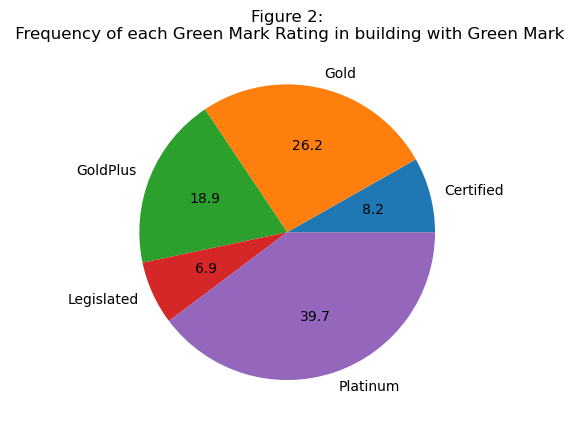

In [14]:
fig, ax = plt.subplots(1,1)
dg = df_gm.groupby('greenmarkrating').count()

plt.pie(dg['greenmarkstatus'],autopct='%.1f',labels=dg.index)

plt.title('Figure 2:\n Frequency of each Green Mark Rating in building with Green Mark')
plt.grid(color=(.9,.9,.9))
#fig.savefig('Figures/Figure 2png')

In [15]:
df_gas = pd.read_csv('data/TotalHouseholdTownGasConsumptionbyDwellingType2005toJun2021.csv', parse_dates=['month'])

df_gas.head()

,month,housing_type,dwelling_type,tg_consumption_gwh
0,2005-01-01,Public Housing,1-Room / 2-Room,1.1
1,2005-01-01,Public Housing,3-Room,6.6
2,2005-01-01,Public Housing,4-Room,16.0
3,2005-01-01,Public Housing,5-Room and Executive,17.4
4,2005-01-01,Private Housing,Private Apartments and Condominiums,5.9


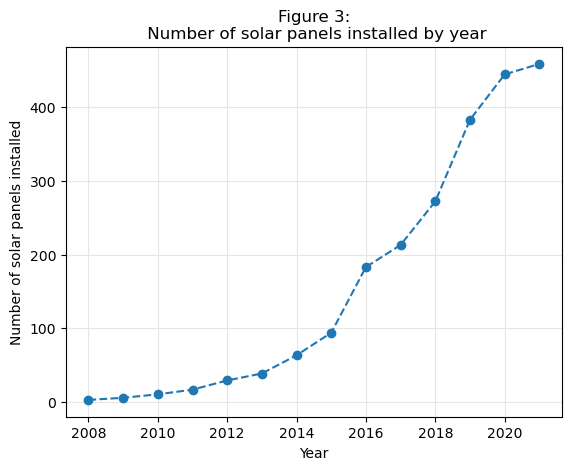

In [16]:
fig, ax = plt.subplots(1,1)
dg_sp = df_sp.groupby('year').mean(numeric_only=True)
plt.plot(dg_sp['num_solar_pv_inst'],linestyle='dashed',marker='o',markersize=6)
plt.title('Figure 3:\n Number of solar panels installed by year')
plt.xlabel('Year')
plt.ylabel('Number of solar panels installed')
plt.grid(color=(.9,.9,.9))
#fig.savefig('Figures/Figure 3.png')

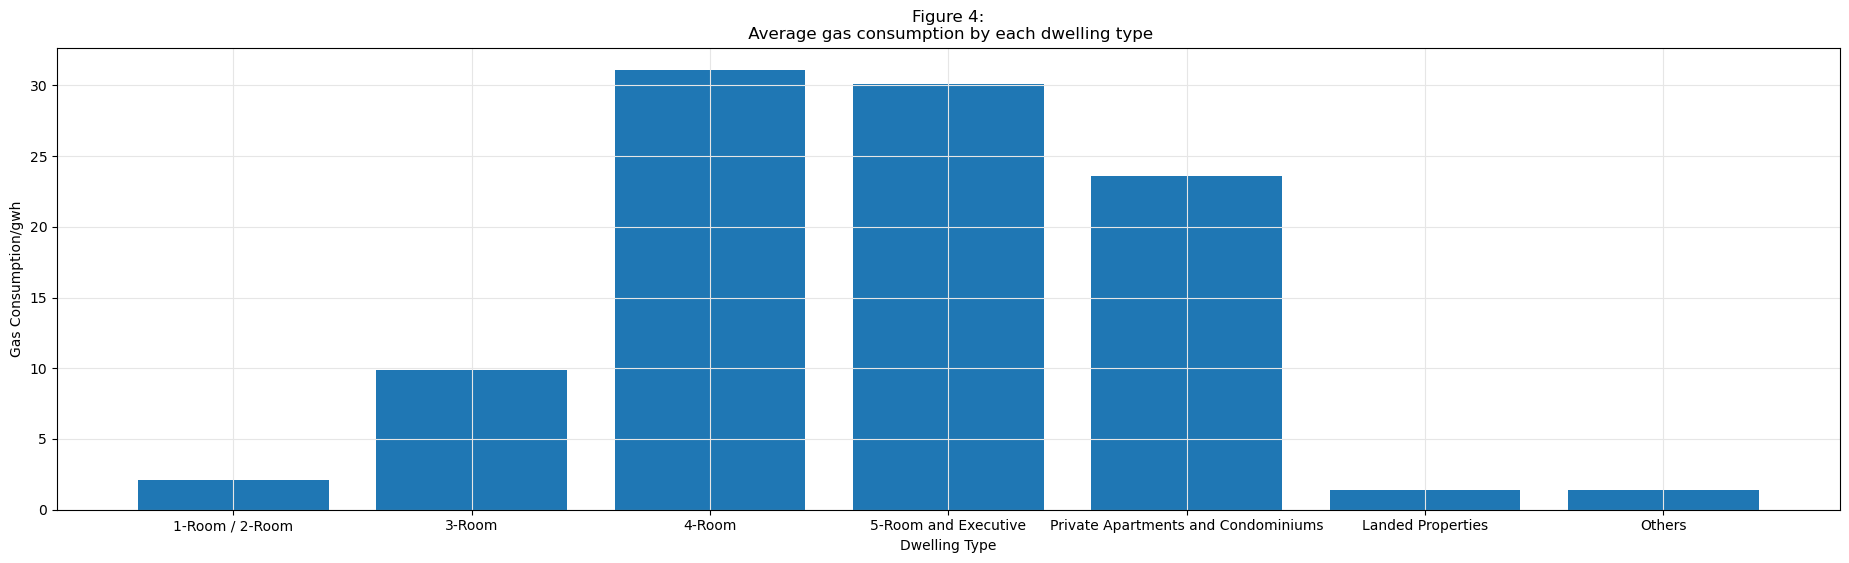

In [17]:
fig, ax = plt.subplots(1,1, figsize=(23, 6))
dg_gas = df_gas.groupby('month').mean(numeric_only=True)
plt.bar(df_gas['dwelling_type'],df_gas['tg_consumption_gwh'])
plt.title('Figure 4:\n Average gas consumption by each dwelling type')
plt.xlabel('Dwelling Type')
plt.ylabel('Gas Consumption/gwh')
plt.grid(color=(.9,.9,.9))
#fig.savefig('Figures/Figure 4.png')

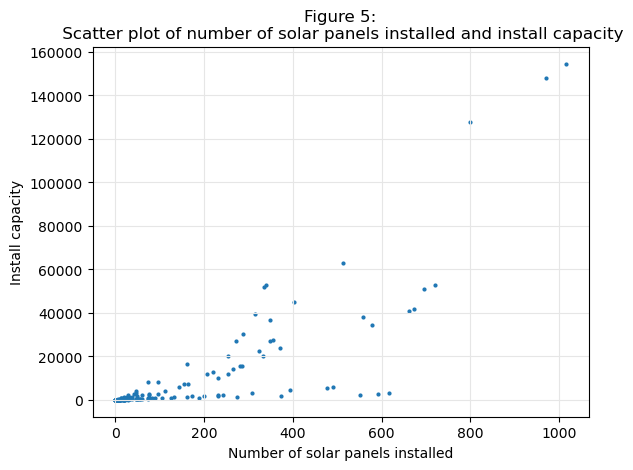

In [18]:
fig, ax = plt.subplots(1,1)

plt.scatter(df_sp['num_solar_pv_inst'], df_sp['inst_cap_kwac'],s=4, label = 'Data')

plt.title('Figure 5:\n Scatter plot of number of solar panels installed and install capacity')
plt.xlabel('Number of solar panels installed')
plt.ylabel('Install capacity')
plt.grid(color=(.9,.9,.9))
#fig.savefig('Figures/Figure 5.png')

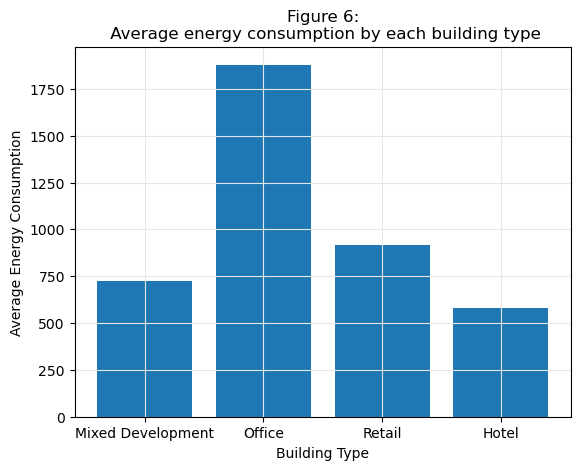

In [19]:
fig, ax = plt.subplots(1,1)

plt.bar(df_gm['mainbuildingfunction'],df_gm['2018'])
plt.title('Figure 6:\n Average energy consumption by each building type')
plt.xlabel('Building Type')
plt.ylabel('Average Energy Consumption')
plt.grid(color=(.9,.9,.9))
#fig.savefig('Figures/Figure 6png')

# e) regression

1. floor area v energy consumption


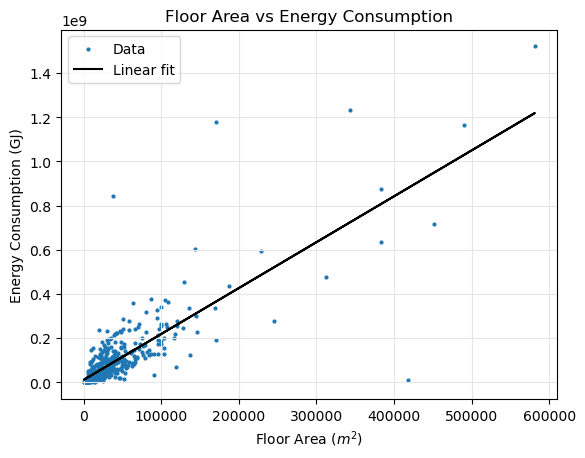

Intercept    1.145091e+07
gfa          2.077266e+03
dtype: float64
For every 1 square meter increase in gfa, theres 2077GJ more energy consumed annually


In [20]:
df_gm.rename(columns={'2020': 'energy_consumption'}, inplace=True)#apparently sm dont like to work with numeric only column titles
df_gm['energy_consumption'] = pd.to_numeric(df_gm['energy_consumption'], errors='coerce',downcast='float')#its a string for some reason also the unit is really dumb 
df_gm['gfasf'] = df_gm['gfa'] * 10.7639 #convert gfa into square ft because the energy consumtion unit(eui) for some reason is calculated in square foot(I Hate imperial system)
df_gm['eca'] = df_gm['gfasf'] * df_gm['energy_consumption']# convert eui into energy consumed annually (in Giga Joule) (thank god i dont need to convert the energy from foot-pound force)
regl_ef = smf.ols('eca ~ gfa', data=df_gm).fit()#use ols to find m and c
df_gm['fit_energy'] = regl_ef.params[0] + regl_ef.params[1]*df_gm['gfa'] #apply
fig, ax = plt.subplots(1,1)
plt.scatter(df_gm['gfa'], df_gm['eca'],s=4, label = 'Data')
plt.plot(df_gm['gfa'],df_gm['fit_energy'],color=(0,0,0), label = 'Linear fit')
plt.title('Floor Area vs Energy Consumption')
plt.xlabel('Floor Area ($m^2$) ')
plt.ylabel('Energy Consumption (GJ)')
plt.legend()
plt.grid(color=(.9,.9,.9))
plt.show()
print(regl_ef.params)
print('For every 1 square meter increase in gfa, theres 2077GJ more energy consumed annually')#interpretation

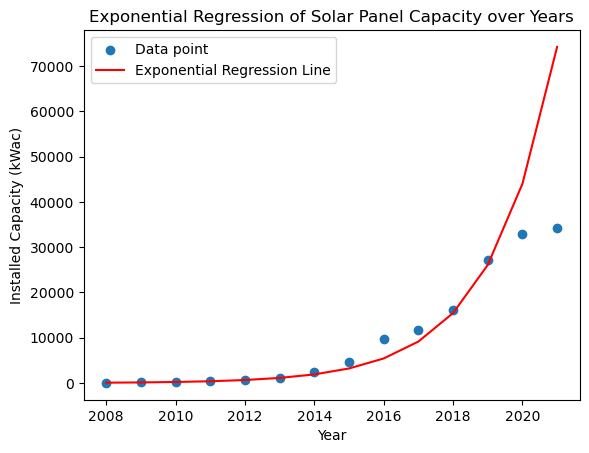

In [62]:
dg_sp['log_inst_cap_kwac'] = np.log(dg_sp['inst_cap_kwac']) # transform for linearization
model = smf.ols('log_inst_cap_kwac ~ year', data=dg_sp).fit() #fit liner model
dg_sp['exp_sp_y'] = np.exp(model.predict(dg_sp['year'])) #find exponential regression line's y with linear model
plt.scatter(dg_sp['year'], dg_sp['inst_cap_kwac'], label='Data point')
plt.plot(dg_sp['year'], dg_sp['exp_sp_y'], color='red', label='Exponential Regression Line')
plt.xlabel('Year')
plt.ylabel('Installed Capacity (kWac)')
plt.title('Exponential Regression of Solar Panel Capacity over Years')
plt.legend()
plt.show() #The graph doesnt seems to fit that well towards the end

Parameters: a = 2057.9066017880627, b = 0.23159185476179545, c = -3746.705727019569
The regression line follows the model y=a*e^(bx)+c
Which indicates that every year the installed capacity of solar panels grows by approximately [(e^0.232)-1]%


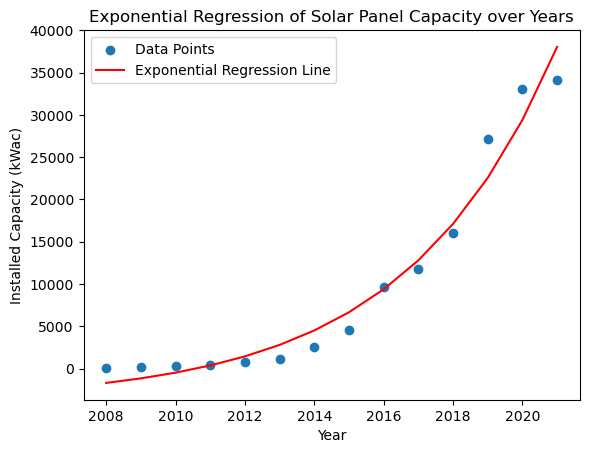

In [63]:
#The last graph seems to have some problem so i decided to fit an exponential model direcly with scipy
from scipy.optimize import curve_fit
def exp_function(x, a, b, c): #define exponential function
    return a * np.exp(b * (x - min(dg_sp['year']))) + c
params, covariance = curve_fit(exp_function, dg_sp['year'], dg_sp['inst_cap_kwac']) #fit the model
plt.scatter(dg_sp['year'], dg_sp['inst_cap_kwac'], label='Data Points')
plt.plot(dg_sp['year'],exp_function(dg_sp['year'], *params), color='red', label='Exponential Regression Line')
plt.xlabel('Year')
plt.ylabel('Installed Capacity (kWac)')
plt.title('Exponential Regression of Solar Panel Capacity over Years')
plt.legend()
print(f"Parameters: a = {params[0]}, b = {params[1]}, c = {params[2]}")
print("The regression line follows the model y=a*e^(bx)+c")
print("Which indicates that every year the installed capacity of solar panels grows by approximately [(e^0.232)-1]%")

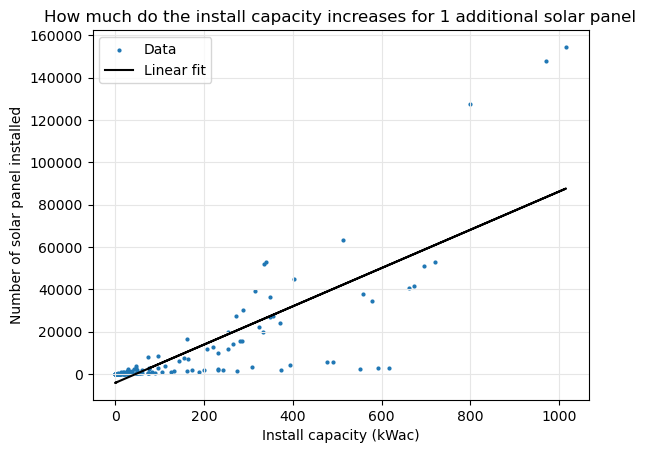

Intercept           -4191.211453
num_solar_pv_inst      90.437557
dtype: float64
For every additional solar panel installed, the total capacity increases by approx  90.437557kWac


In [118]:
reg1 = smf.ols("inst_cap_kwac ~ num_solar_pv_inst", data = df_sp).fit() #fit liner model
df_sp['fit_cap'] = reg1.params[0] + reg1.params[1]*df_sp['num_solar_pv_inst']
fig, ax = plt.subplots(1,1)
plt.scatter(df_sp['num_solar_pv_inst'], df_sp['inst_cap_kwac'],s=4, label = 'Data')
plt.plot(df_sp['num_solar_pv_inst'],df_sp['fit_cap'],color=(0,0,0), label = 'Linear fit')
plt.title('How much do the install capacity increases for 1 additional solar panel')
plt.xlabel('Install capacity (kWac)')
plt.ylabel('Number of solar panel installed')
plt.legend()
plt.grid(color=(.9,.9,.9))
plt.show()
print(reg1.params)
print("For every additional solar panel installed, the total capacity increases by approx  90.437557kWac")

# f)Location

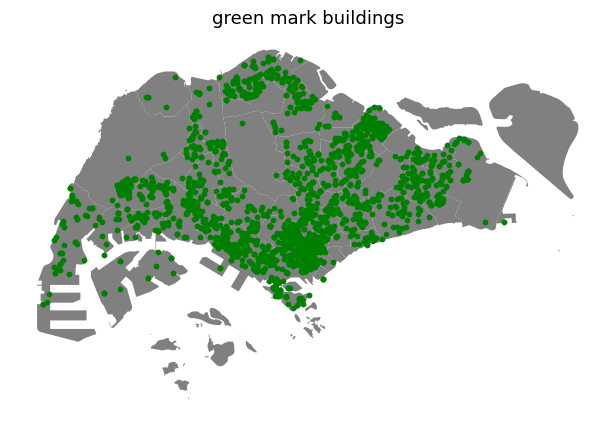

In [80]:
fig, axis = plt.subplots(1,1,figsize=(8,5))
dg_pa.plot(ax=axis,color='grey')
dg_gm.plot(ax=axis,color='green',markersize=10)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('Green mark buildings',fontsize=13)
plt.show()

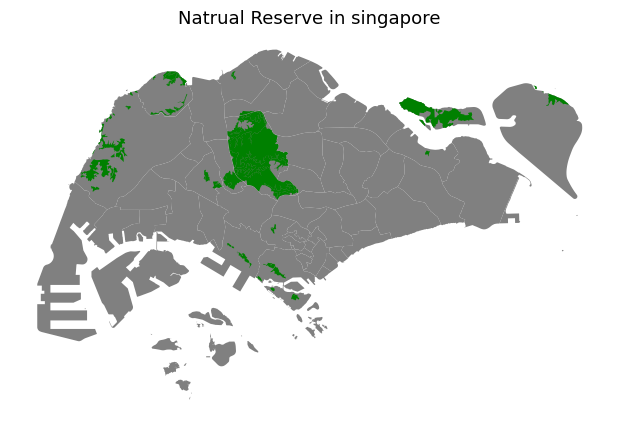

In [117]:
fig, axis = plt.subplots(1,1,figsize=(8,5))
dg_pl.plot(ax=axis,color='grey')
dg_nb.plot(ax=axis,color='green')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('Natrual Reserve in singapore',fontsize=13)
plt.show()